In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('../')

In [12]:
from Modules.scraping import *
from Modules.supportFunctions import *
from Modules.fittingFunction import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
dat = scrap_covid_data()

# START scraping
### Requesting url nr 1
### Requesting url nr 2
### Requesting url nr 3
# END scraping


In [6]:
data = cut_down(dat)

In [20]:
def find_timepoint_zero(df):
    df["Timepoint"] = -1

    point_zero = df.loc[df['Infected']>0, "Date"][0]
    df.loc[df['Date'] == point_zero, "Timepoint"] = 0

    previous = -1
    for i, row in df.iterrows():
        if i == point_zero or previous != -1:
            previous = previous + 1
            df.at[i,'Timepoint'] = previous
            
    return df

In [21]:
# Get German data
DE = country_filter(data, Country='Germany')
DE = find_timepoint_zero(DE)
DE = DE[DE.Timepoint != -1]

### Plot growth rate of Covid 19 in Germany

Text(0,0.5,'New_Infections')

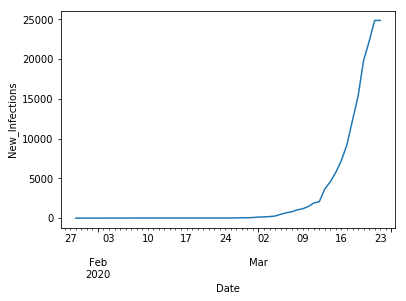

In [22]:
fig, ax = plt.subplots()
DE.loc[:,'Infected'].iloc[1:].plot()
ax.set_ylabel('New_Infections')

### Plot log of growth rate of Covid 19 in Germany

Text(0,0.5,'New_Infections')

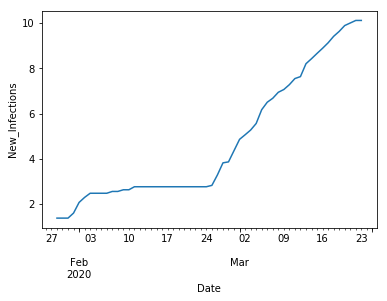

In [38]:
fig, ax = plt.subplots()
np.log(DE.loc[:,'Infected'].iloc[1:]).plot()
ax.set_ylabel('New_Infections')

### Analyse the stationarity of the time series 

In [93]:
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
print('AdFuller:',adfuller(np.log(DE.loc[:,'Infected']).diff()[1:])[1])
print('KPSS:',kpss(np.log(DE.loc[:,'Infected']).diff()[1:])[1])

AdFuller: 0.14757013449560769
KPSS: 0.1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Indicates AR 1 Process


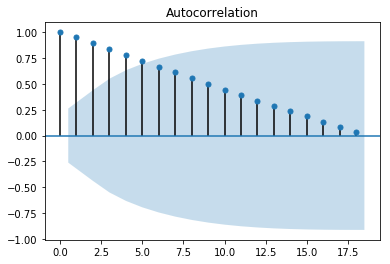

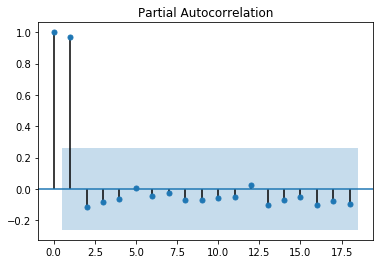

In [95]:
plot_acf(np.log(DE.loc[:,'Infected'])[1:])
plot_pacf(np.log(DE.loc[:,'Infected'])[1:])
print('Indicates AR 1 Process')

### Fit ARIMA model with Auto ARIMA 

In [96]:
from pyramid.arima import auto_arima
stepwise_model = auto_arima(np.log(DE.loc[:,'Infected'])[1:], start_p=0, start_q=0,
                           max_p=1, max_q=1, m=1,
                           start_P=0, seasonal=False,
                           d=1, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 1, 0); AIC=-32.896, BIC=-28.882, Fit time=0.013 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-45.697, BIC=-39.675, Fit time=0.033 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-42.298, BIC=-36.276, Fit time=0.031 seconds
Fit ARIMA: order=(1, 1, 1); AIC=-46.154, BIC=-38.125, Fit time=0.078 seconds
Total fit time: 0.159 seconds
-46.154339714686046


### Forecasting 

In [97]:
train = pd.Series(np.log(DE.loc[:,'Infected'])[1:-3])
test = pd.Series(np.log(DE.loc[:,'Infected'])[-3:])
stepwise_model.fit(train)
future_forecast = stepwise_model.predict(n_periods=3)
#Back transformation
train, test, future_forecast = np.exp(train), np.exp(test) , np.exp(future_forecast)
print(future_forecast)

[24822.73873714 30795.46311157 37940.21474327]


In [98]:
future_forecast = pd.Series(future_forecast, index= test.index)
test_series = train.append(test)
forecast_series = train.append(future_forecast)

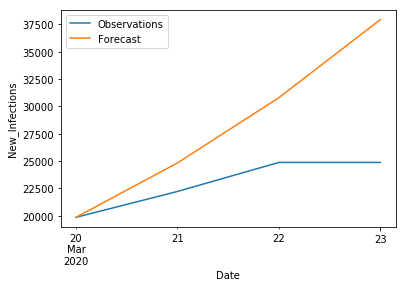

In [99]:
fig, ax = plt.subplots()
test_series.iloc[-4:].plot()
forecast_series.iloc[-4:].plot()
ax.set_ylabel('New_Infections')
ax.legend(['Observations', 'Forecast'])

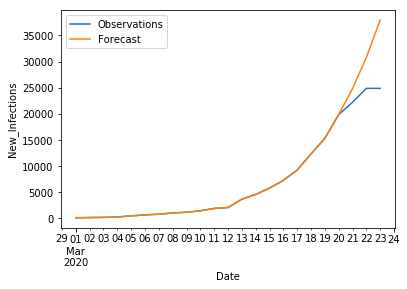

In [100]:
fig, ax = plt.subplots()
test_series.loc['2020-03-01':].plot()
forecast_series.loc['2020-03-01':].plot()
ax.set_ylabel('New_Infections')
ax.legend(['Observations', 'Forecast'])

# Model growth rate of Covid 19 in China 
## Fit Richards model to growth rates and extract parameters

In [101]:
#Get the Data 
CH = country_filter(data, Country='China')
state_list = CH['Province/State'].drop_duplicates()

### Example: Fit Richards model to Data in Hebei 

In [130]:
y = np.array(CH.loc[CH['Province/State']=='Chongqing','Infected'].transform(lambda x: x*(100/x.max())))
x = np.array(range(0,len(y)),dtype=float)
params,_ = fit(logistic,x,y)

Text(0,0.5,'Number of Infections')

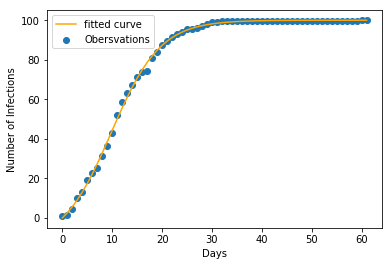

In [131]:
fig, axes = plt.subplots()
plt.scatter(x,y)
plt.plot(x,logistic(x,params[0],params[1],params[2],params[3],params[4]),color='orange')
axes.legend(['fitted curve','Obersvations'])
axes.set_xlabel('Days')
axes.set_ylabel('Number of Infections in %')

### Fit the Richards model for each state & extract parameters

In [132]:
params = list()
missing_states = list()
for state in state_list:
    y = CH.loc[CH['Province/State']==state,'Infected'].transform(lambda x: x*(100/x.max()))
    x = np.array(range(0,len(y)),dtype=float)
    try:
        new_params,_ = fit(logistic,x,y)
        params.append(new_params)
    except:
        print('Couldnt fit:',state)
        missing_states.append(state)        
fit_state = state_list.loc[~np.isin(state_list,missing_states)]
target = pd.DataFrame(params, columns=['A', 'u', 'd', 'v', 'y0'], index = fit_state)    
        

Couldnt fit: Gansu
Couldnt fit: Macau
Couldnt fit: Hong Kong


In [126]:
target.head

<bound method NDFrame.head of                          A            u          d    v            y0
Province/State                                                       
Zhejiang        107.439447     7.128990   2.194232  0.1 -9.552904e+00
Shanghai         98.402928     5.108809  -0.079880  0.1 -1.212406e+01
Guangxi         108.394336     5.317202   0.968605  0.1 -8.712075e+00
Hebei           105.490713     5.492770   4.667273  0.1 -5.298677e+00
Qinghai         104.473192     9.454880   3.207828  0.1 -3.898154e+00
Shanxi          104.315915     7.390130   4.174854  0.1 -4.351805e+00
Guangdong       102.571240     6.310242   3.022154  0.1 -6.431621e+00
Anhui           102.715243     6.925646   5.679311  0.1 -2.411782e+00
Yunnan          127.861689     6.270757  -2.682116  0.1 -2.858245e+01
Heilongjiang    101.824875     6.661722   7.901903  0.1 -2.097486e+00
Ningxia         109.173993     4.918669   2.165271  0.1 -9.274098e+00
Sichuan         117.427504     4.914631  -0.867800  0.1 -1.7